# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Thu Mar 26 06:26:46 2020


In [2]:
import src
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.albumentationstransforms as preprocessing
import src.utils.utils as utils
import src.train.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.customcompose as customcompose
from src.train.lrfinder.lrfinder import LRFinder


%config IPCompleter.greedy=True

%reload_ext autoreload


In [3]:
%autoreload 2  # Autoreload all modules

In [4]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)

In [5]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
      print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
      print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
      print('re-execute this cell.')
    else:
      print('You are using a high-RAM runtime!')

In [6]:
import torch
print(torch.__version__)

1.4.0


In [7]:
# mean,std= utils.Utils.calculatemeanandstddeviation()
# print("mean: " + str(mean))
# print("std: " + str(std))
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

In [8]:
ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
batch_size = 128
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

CUDA Available? True
128


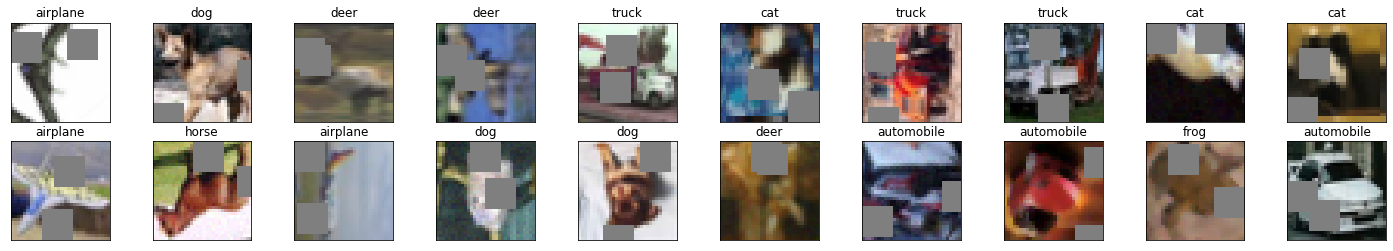

In [10]:
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()

#TODO show transformed images fom dataset
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [11]:
cnn_model, device = utils.Utils.createmodelresnet18()
train_model = train.TrainModel()
train_model.showmodelsummary(cnn_model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [12]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.06, momentum=0.9, weight_decay=0, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()


Learning rate search finished. See the graph with {finder_name}.plot()


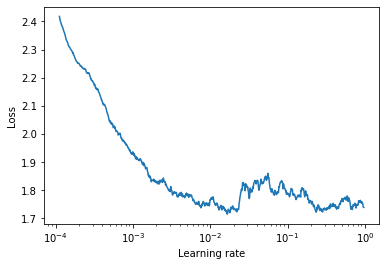

In [13]:
lr_finder = LRFinder(cnn_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=0.0001,end_lr=1, num_iter=1000, step_mode="exp")
lr_finder.plot()

In [14]:
lr_finder.reset()

In [15]:
lr_finder.range_test(train_loader, val_loader=test_loader, start_lr=0.0001,end_lr=1, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


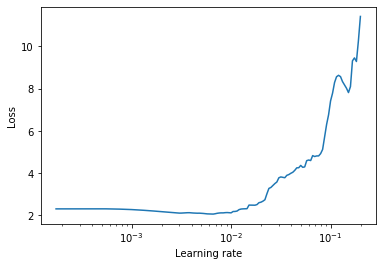

In [16]:
lr_finder.plot(skip_end=0)

In [17]:
lr_finder.reset()

In [13]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.08, momentum=0.9, weight_decay=0, nesterov=True)
scheduler = utils.Utils.createscheduler(optimizer, mode='max', factor=0.9, patience=2,
                                        verbose=True)

In [14]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 100
for epoch in range(1, epochs+1):
    print("EPOCH:", epoch)
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(model=cnn_model, device=device, test_loader=test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch, lr_data=lr_data)
    scheduler.step(t_acc_epoch)
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch + 1)  # print LR for different epochs
        lr_data.append(param_groups['lr'])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.6583538055419922 Batch_id=390 Accuracy=28.30: 100%|██████████| 391/391 [01:12<00:00,  5.38it/s]



Test set: Average loss: 0.0131, Accuracy: 3917/10000 (39.17%)

Validation accuracy increased (0.000000 --> 39.170000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  2
EPOCH: 2


Loss=1.8447344303131104 Batch_id=390 Accuracy=37.07: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s]



Test set: Average loss: 0.0117, Accuracy: 4636/10000 (46.36%)

Validation accuracy increased (39.170000 --> 46.360000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  3
EPOCH: 3


Loss=1.5772278308868408 Batch_id=390 Accuracy=41.43: 100%|██████████| 391/391 [02:18<00:00,  2.82it/s]



Test set: Average loss: 0.0111, Accuracy: 4879/10000 (48.79%)

Validation accuracy increased (46.360000 --> 48.790000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  4
EPOCH: 4


Loss=1.37063729763031 Batch_id=390 Accuracy=45.01: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]  



Test set: Average loss: 0.0102, Accuracy: 5357/10000 (53.57%)

Validation accuracy increased (48.790000 --> 53.570000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  5
EPOCH: 5


Loss=1.185063362121582 Batch_id=390 Accuracy=48.24: 100%|██████████| 391/391 [02:23<00:00,  2.72it/s] 



Test set: Average loss: 0.0092, Accuracy: 5812/10000 (58.12%)

Validation accuracy increased (53.570000 --> 58.120000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  6
EPOCH: 6


Loss=1.3341553211212158 Batch_id=390 Accuracy=51.04: 100%|██████████| 391/391 [02:27<00:00,  2.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 5748/10000 (57.48%)

Learning rate = 0.08  for epoch:  7
EPOCH: 7


Loss=1.398844838142395 Batch_id=390 Accuracy=53.23: 100%|██████████| 391/391 [02:23<00:00,  2.73it/s] 



Test set: Average loss: 0.0084, Accuracy: 6161/10000 (61.61%)

Validation accuracy increased (58.120000 --> 61.610000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  8
EPOCH: 8


Loss=1.4507017135620117 Batch_id=390 Accuracy=55.07: 100%|██████████| 391/391 [02:26<00:00,  2.67it/s]



Test set: Average loss: 0.0077, Accuracy: 6517/10000 (65.17%)

Validation accuracy increased (61.610000 --> 65.170000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  9
EPOCH: 9


Loss=1.371017336845398 Batch_id=390 Accuracy=57.34: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s] 



Test set: Average loss: 0.0074, Accuracy: 6675/10000 (66.75%)

Validation accuracy increased (65.170000 --> 66.750000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  10
EPOCH: 10


Loss=1.3994896411895752 Batch_id=390 Accuracy=59.11: 100%|██████████| 391/391 [02:22<00:00,  2.74it/s]



Test set: Average loss: 0.0074, Accuracy: 6771/10000 (67.71%)

Validation accuracy increased (66.750000 --> 67.710000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  11
EPOCH: 11


Loss=1.1365500688552856 Batch_id=390 Accuracy=60.38: 100%|██████████| 391/391 [02:27<00:00,  2.66it/s]



Test set: Average loss: 0.0069, Accuracy: 7010/10000 (70.10%)

Validation accuracy increased (67.710000 --> 70.100000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  12
EPOCH: 12


Loss=0.8934009671211243 Batch_id=390 Accuracy=61.98: 100%|██████████| 391/391 [02:24<00:00,  2.70it/s]



Test set: Average loss: 0.0068, Accuracy: 7063/10000 (70.63%)

Validation accuracy increased (70.100000 --> 70.630000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  13
EPOCH: 13


Loss=1.0773494243621826 Batch_id=390 Accuracy=63.15: 100%|██████████| 391/391 [02:30<00:00,  2.60it/s]



Test set: Average loss: 0.0061, Accuracy: 7341/10000 (73.41%)

Validation accuracy increased (70.630000 --> 73.410000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  14
EPOCH: 14


Loss=1.1797657012939453 Batch_id=390 Accuracy=64.11: 100%|██████████| 391/391 [02:24<00:00,  2.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7312/10000 (73.12%)

Learning rate = 0.08  for epoch:  15
EPOCH: 15


Loss=0.784953773021698 Batch_id=390 Accuracy=65.90: 100%|██████████| 391/391 [02:27<00:00,  2.65it/s] 



Test set: Average loss: 0.0055, Accuracy: 7541/10000 (75.41%)

Validation accuracy increased (73.410000 --> 75.410000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  16
EPOCH: 16


Loss=0.7918974757194519 Batch_id=390 Accuracy=66.57: 100%|██████████| 391/391 [02:20<00:00,  2.79it/s]



Test set: Average loss: 0.0055, Accuracy: 7647/10000 (76.47%)

Validation accuracy increased (75.410000 --> 76.470000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  17
EPOCH: 17


Loss=0.8475763201713562 Batch_id=390 Accuracy=67.51: 100%|██████████| 391/391 [02:24<00:00,  2.70it/s]



Test set: Average loss: 0.0054, Accuracy: 7648/10000 (76.48%)

Validation accuracy increased (76.470000 --> 76.480000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  18
EPOCH: 18


Loss=0.9575434923171997 Batch_id=390 Accuracy=68.53: 100%|██████████| 391/391 [02:23<00:00,  2.72it/s]



Test set: Average loss: 0.0050, Accuracy: 7795/10000 (77.95%)

Validation accuracy increased (76.480000 --> 77.950000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  19
EPOCH: 19


Loss=0.9148460626602173 Batch_id=390 Accuracy=69.31: 100%|██████████| 391/391 [02:24<00:00,  2.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7688/10000 (76.88%)

Learning rate = 0.08  for epoch:  20
EPOCH: 20


Loss=0.8047932386398315 Batch_id=390 Accuracy=70.11: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]



Test set: Average loss: 0.0049, Accuracy: 7900/10000 (79.00%)

Validation accuracy increased (77.950000 --> 79.000000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  21
EPOCH: 21


Loss=0.8595302700996399 Batch_id=390 Accuracy=71.15: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]



Test set: Average loss: 0.0046, Accuracy: 7987/10000 (79.87%)

Validation accuracy increased (79.000000 --> 79.870000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  22
EPOCH: 22


Loss=0.9710096120834351 Batch_id=390 Accuracy=71.64: 100%|██████████| 391/391 [02:22<00:00,  2.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7986/10000 (79.86%)

Learning rate = 0.08  for epoch:  23
EPOCH: 23


Loss=0.9727412462234497 Batch_id=390 Accuracy=72.09: 100%|██████████| 391/391 [02:24<00:00,  2.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7898/10000 (78.98%)

Learning rate = 0.08  for epoch:  24
EPOCH: 24


Loss=0.8585802316665649 Batch_id=390 Accuracy=72.88: 100%|██████████| 391/391 [02:22<00:00,  2.73it/s]



Test set: Average loss: 0.0044, Accuracy: 8028/10000 (80.28%)

Validation accuracy increased (79.870000 --> 80.280000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    24: reducing learning rate of group 0 to 7.2000e-02.
Learning rate = 0.07200000000000001  for epoch:  25
EPOCH: 25


Loss=0.7372202277183533 Batch_id=390 Accuracy=73.65: 100%|██████████| 391/391 [02:23<00:00,  2.72it/s]



Test set: Average loss: 0.0041, Accuracy: 8222/10000 (82.22%)

Validation accuracy increased (80.280000 --> 82.220000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  26
EPOCH: 26


Loss=0.43676286935806274 Batch_id=390 Accuracy=74.07: 100%|██████████| 391/391 [02:23<00:00,  2.72it/s]



Test set: Average loss: 0.0040, Accuracy: 8254/10000 (82.54%)

Validation accuracy increased (82.220000 --> 82.540000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  27
EPOCH: 27


Loss=0.9866421818733215 Batch_id=390 Accuracy=74.87: 100%|██████████| 391/391 [02:27<00:00,  2.66it/s]



Test set: Average loss: 0.0038, Accuracy: 8369/10000 (83.69%)

Validation accuracy increased (82.540000 --> 83.690000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  28
EPOCH: 28


Loss=0.6158910989761353 Batch_id=390 Accuracy=75.51: 100%|██████████| 391/391 [02:22<00:00,  2.75it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8294/10000 (82.94%)

Learning rate = 0.07200000000000001  for epoch:  29
EPOCH: 29


Loss=0.44427281618118286 Batch_id=390 Accuracy=75.46: 100%|██████████| 391/391 [02:27<00:00,  2.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8285/10000 (82.85%)

Learning rate = 0.07200000000000001  for epoch:  30
EPOCH: 30


Loss=0.9625110626220703 Batch_id=390 Accuracy=76.51: 100%|██████████| 391/391 [02:22<00:00,  2.73it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8299/10000 (82.99%)

Epoch    30: reducing learning rate of group 0 to 6.4800e-02.
Learning rate = 0.06480000000000001  for epoch:  31
EPOCH: 31


Loss=0.8439348340034485 Batch_id=390 Accuracy=76.86: 100%|██████████| 391/391 [02:23<00:00,  2.73it/s] 



Test set: Average loss: 0.0035, Accuracy: 8461/10000 (84.61%)

Validation accuracy increased (83.690000 --> 84.610000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06480000000000001  for epoch:  32
EPOCH: 32


Loss=0.4713270664215088 Batch_id=390 Accuracy=77.10: 100%|██████████| 391/391 [02:23<00:00,  2.72it/s] 



Test set: Average loss: 0.0034, Accuracy: 8551/10000 (85.51%)

Validation accuracy increased (84.610000 --> 85.510000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06480000000000001  for epoch:  33
EPOCH: 33


Loss=0.5572474002838135 Batch_id=390 Accuracy=77.91: 100%|██████████| 391/391 [02:21<00:00,  2.77it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8370/10000 (83.70%)

Learning rate = 0.06480000000000001  for epoch:  34
EPOCH: 34


Loss=0.5474256277084351 Batch_id=390 Accuracy=78.04: 100%|██████████| 391/391 [02:21<00:00,  2.77it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8346/10000 (83.46%)

Learning rate = 0.06480000000000001  for epoch:  35
EPOCH: 35


Loss=0.8125384449958801 Batch_id=390 Accuracy=78.69: 100%|██████████| 391/391 [02:28<00:00,  2.63it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8499/10000 (84.99%)

Epoch    35: reducing learning rate of group 0 to 5.8320e-02.
Learning rate = 0.05832000000000001  for epoch:  36
EPOCH: 36


Loss=0.6429003477096558 Batch_id=390 Accuracy=78.83: 100%|██████████| 391/391 [02:26<00:00,  2.67it/s] 



Test set: Average loss: 0.0033, Accuracy: 8617/10000 (86.17%)

Validation accuracy increased (85.510000 --> 86.170000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.05832000000000001  for epoch:  37
EPOCH: 37


Loss=0.506389856338501 Batch_id=390 Accuracy=79.44: 100%|██████████| 391/391 [02:26<00:00,  2.67it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8548/10000 (85.48%)

Learning rate = 0.05832000000000001  for epoch:  38
EPOCH: 38


Loss=0.743473470211029 Batch_id=390 Accuracy=79.85: 100%|██████████| 391/391 [02:26<00:00,  2.68it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8494/10000 (84.94%)

Epoch    38: reducing learning rate of group 0 to 5.2488e-02.
Learning rate = 0.052488000000000014  for epoch:  39
EPOCH: 39


Loss=0.5643147230148315 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8613/10000 (86.13%)

Learning rate = 0.052488000000000014  for epoch:  40
EPOCH: 40


Loss=0.5975726842880249 Batch_id=390 Accuracy=80.65: 100%|██████████| 391/391 [02:24<00:00,  2.70it/s] 



Test set: Average loss: 0.0032, Accuracy: 8677/10000 (86.77%)

Validation accuracy increased (86.170000 --> 86.770000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.052488000000000014  for epoch:  41
EPOCH: 41


Loss=0.7139478921890259 Batch_id=390 Accuracy=80.79: 100%|██████████| 391/391 [02:25<00:00,  2.68it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8625/10000 (86.25%)

Learning rate = 0.052488000000000014  for epoch:  42
EPOCH: 42


Loss=0.5252397060394287 Batch_id=390 Accuracy=81.16: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8572/10000 (85.72%)

Learning rate = 0.052488000000000014  for epoch:  43
EPOCH: 43


Loss=0.5354421138763428 Batch_id=390 Accuracy=81.07: 100%|██████████| 391/391 [02:26<00:00,  2.67it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8638/10000 (86.38%)

Epoch    43: reducing learning rate of group 0 to 4.7239e-02.
Learning rate = 0.047239200000000016  for epoch:  44
EPOCH: 44


Loss=0.8565371632575989 Batch_id=390 Accuracy=81.78: 100%|██████████| 391/391 [02:32<00:00,  2.56it/s] 



Test set: Average loss: 0.0031, Accuracy: 8689/10000 (86.89%)

Validation accuracy increased (86.770000 --> 86.890000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.047239200000000016  for epoch:  45
EPOCH: 45


Loss=0.41427096724510193 Batch_id=390 Accuracy=82.02: 100%|██████████| 391/391 [02:26<00:00,  2.68it/s]



Test set: Average loss: 0.0031, Accuracy: 8689/10000 (86.89%)

Validation accuracy increased (86.890000 --> 86.890000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.047239200000000016  for epoch:  46
EPOCH: 46


Loss=0.522724449634552 Batch_id=390 Accuracy=82.31: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s]  



Test set: Average loss: 0.0032, Accuracy: 8709/10000 (87.09%)

Validation accuracy increased (86.890000 --> 87.090000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    46: reducing learning rate of group 0 to 4.2515e-02.
Learning rate = 0.042515280000000016  for epoch:  47
EPOCH: 47


Loss=0.47928276658058167 Batch_id=390 Accuracy=83.05: 100%|██████████| 391/391 [02:24<00:00,  2.70it/s]



Test set: Average loss: 0.0030, Accuracy: 8737/10000 (87.37%)

Validation accuracy increased (87.090000 --> 87.370000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.042515280000000016  for epoch:  48
EPOCH: 48


Loss=0.5547969937324524 Batch_id=390 Accuracy=83.07: 100%|██████████| 391/391 [02:27<00:00,  2.64it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8714/10000 (87.14%)

Learning rate = 0.042515280000000016  for epoch:  49
EPOCH: 49


Loss=0.5266090631484985 Batch_id=390 Accuracy=83.25: 100%|██████████| 391/391 [02:30<00:00,  2.59it/s] 



Test set: Average loss: 0.0029, Accuracy: 8775/10000 (87.75%)

Validation accuracy increased (87.370000 --> 87.750000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.042515280000000016  for epoch:  50
EPOCH: 50


Loss=0.6524729132652283 Batch_id=390 Accuracy=83.44: 100%|██████████| 391/391 [02:31<00:00,  2.58it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8752/10000 (87.52%)

Learning rate = 0.042515280000000016  for epoch:  51
EPOCH: 51


Loss=0.4495108723640442 Batch_id=390 Accuracy=83.77: 100%|██████████| 391/391 [02:27<00:00,  2.64it/s] 



Test set: Average loss: 0.0029, Accuracy: 8795/10000 (87.95%)

Validation accuracy increased (87.750000 --> 87.950000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.042515280000000016  for epoch:  52
EPOCH: 52


Loss=0.3990496098995209 Batch_id=390 Accuracy=83.88: 100%|██████████| 391/391 [02:29<00:00,  2.62it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8758/10000 (87.58%)

Epoch    52: reducing learning rate of group 0 to 3.8264e-02.
Learning rate = 0.03826375200000002  for epoch:  53
EPOCH: 53


Loss=0.40272068977355957 Batch_id=390 Accuracy=84.00: 100%|██████████| 391/391 [02:29<00:00,  2.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8776/10000 (87.76%)

Learning rate = 0.03826375200000002  for epoch:  54
EPOCH: 54


Loss=0.48544391989707947 Batch_id=390 Accuracy=84.40: 100%|██████████| 391/391 [02:30<00:00,  2.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8743/10000 (87.43%)

Learning rate = 0.03826375200000002  for epoch:  55
EPOCH: 55


Loss=0.5991972088813782 Batch_id=390 Accuracy=84.62: 100%|██████████| 391/391 [02:28<00:00,  2.64it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8789/10000 (87.89%)

Epoch    55: reducing learning rate of group 0 to 3.4437e-02.
Learning rate = 0.034437376800000016  for epoch:  56
EPOCH: 56


Loss=0.3798306882381439 Batch_id=390 Accuracy=85.07: 100%|██████████| 391/391 [02:31<00:00,  2.58it/s] 



Test set: Average loss: 0.0029, Accuracy: 8816/10000 (88.16%)

Validation accuracy increased (87.950000 --> 88.160000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.034437376800000016  for epoch:  57
EPOCH: 57


Loss=0.5097132921218872 Batch_id=390 Accuracy=85.29: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s] 



Test set: Average loss: 0.0027, Accuracy: 8895/10000 (88.95%)

Validation accuracy increased (88.160000 --> 88.950000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.034437376800000016  for epoch:  58
EPOCH: 58


Loss=0.4873833656311035 Batch_id=390 Accuracy=85.14: 100%|██████████| 391/391 [02:28<00:00,  2.64it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8826/10000 (88.26%)

Learning rate = 0.034437376800000016  for epoch:  59
EPOCH: 59


Loss=0.4568605422973633 Batch_id=390 Accuracy=85.49: 100%|██████████| 391/391 [02:31<00:00,  2.59it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8835/10000 (88.35%)

Learning rate = 0.034437376800000016  for epoch:  60
EPOCH: 60


Loss=0.4617268145084381 Batch_id=390 Accuracy=85.70: 100%|██████████| 391/391 [02:32<00:00,  2.57it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8821/10000 (88.21%)

Epoch    60: reducing learning rate of group 0 to 3.0994e-02.
Learning rate = 0.030993639120000017  for epoch:  61
EPOCH: 61


Loss=0.5621505975723267 Batch_id=390 Accuracy=85.88: 100%|██████████| 391/391 [02:28<00:00,  2.63it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8872/10000 (88.72%)

Learning rate = 0.030993639120000017  for epoch:  62
EPOCH: 62


Loss=0.669292151927948 Batch_id=390 Accuracy=86.12: 100%|██████████| 391/391 [02:28<00:00,  2.64it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8846/10000 (88.46%)

Learning rate = 0.030993639120000017  for epoch:  63
EPOCH: 63


Loss=0.2900075316429138 Batch_id=390 Accuracy=86.44: 100%|██████████| 391/391 [02:30<00:00,  2.60it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8822/10000 (88.22%)

Epoch    63: reducing learning rate of group 0 to 2.7894e-02.
Learning rate = 0.027894275208000016  for epoch:  64
EPOCH: 64


Loss=0.38925257325172424 Batch_id=390 Accuracy=86.47: 100%|██████████| 391/391 [02:33<00:00,  2.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8848/10000 (88.48%)

Learning rate = 0.027894275208000016  for epoch:  65
EPOCH: 65


Loss=0.5043053030967712 Batch_id=390 Accuracy=86.77: 100%|██████████| 391/391 [02:34<00:00,  2.53it/s] 



Test set: Average loss: 0.0028, Accuracy: 8899/10000 (88.99%)

Validation accuracy increased (88.950000 --> 88.990000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.027894275208000016  for epoch:  66
EPOCH: 66


Loss=0.37846583127975464 Batch_id=390 Accuracy=86.94: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8886/10000 (88.86%)

Epoch    66: reducing learning rate of group 0 to 2.5105e-02.
Learning rate = 0.025104847687200015  for epoch:  67
EPOCH: 67


Loss=0.4171110689640045 Batch_id=390 Accuracy=87.22: 100%|██████████| 391/391 [01:44<00:00,  3.75it/s] 



Test set: Average loss: 0.0028, Accuracy: 8902/10000 (89.02%)

Validation accuracy increased (88.990000 --> 89.020000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.025104847687200015  for epoch:  68
EPOCH: 68


Loss=0.48926353454589844 Batch_id=390 Accuracy=87.27: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]



Test set: Average loss: 0.0028, Accuracy: 8910/10000 (89.10%)

Validation accuracy increased (89.020000 --> 89.100000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.025104847687200015  for epoch:  69
EPOCH: 69


Loss=0.4372304081916809 Batch_id=390 Accuracy=87.37: 100%|██████████| 391/391 [01:41<00:00,  3.87it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8901/10000 (89.01%)

Epoch    69: reducing learning rate of group 0 to 2.2594e-02.
Learning rate = 0.022594362918480014  for epoch:  70
EPOCH: 70


Loss=0.3727737069129944 Batch_id=390 Accuracy=87.68: 100%|██████████| 391/391 [01:43<00:00,  3.77it/s] 



Test set: Average loss: 0.0027, Accuracy: 8946/10000 (89.46%)

Validation accuracy increased (89.100000 --> 89.460000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.022594362918480014  for epoch:  71
EPOCH: 71


Loss=0.11803462356328964 Batch_id=390 Accuracy=88.00: 100%|██████████| 391/391 [01:42<00:00,  3.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8941/10000 (89.41%)

Learning rate = 0.022594362918480014  for epoch:  72
EPOCH: 72


Loss=0.2664678394794464 Batch_id=390 Accuracy=88.21: 100%|██████████| 391/391 [01:43<00:00,  3.76it/s] 



Test set: Average loss: 0.0027, Accuracy: 8950/10000 (89.50%)

Validation accuracy increased (89.460000 --> 89.500000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    72: reducing learning rate of group 0 to 2.0335e-02.
Learning rate = 0.020334926626632013  for epoch:  73
EPOCH: 73


Loss=0.34327539801597595 Batch_id=390 Accuracy=88.16: 100%|██████████| 391/391 [01:38<00:00,  3.97it/s]



Test set: Average loss: 0.0026, Accuracy: 8970/10000 (89.70%)

Validation accuracy increased (89.500000 --> 89.700000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.020334926626632013  for epoch:  74
EPOCH: 74


Loss=0.26848286390304565 Batch_id=390 Accuracy=88.35: 100%|██████████| 391/391 [01:40<00:00,  3.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8961/10000 (89.61%)

Learning rate = 0.020334926626632013  for epoch:  75
EPOCH: 75


Loss=0.2688400447368622 Batch_id=390 Accuracy=88.45: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8936/10000 (89.36%)

Epoch    75: reducing learning rate of group 0 to 1.8301e-02.
Learning rate = 0.018301433963968813  for epoch:  76
EPOCH: 76


Loss=0.4135909974575043 Batch_id=390 Accuracy=88.64: 100%|██████████| 391/391 [01:40<00:00,  3.88it/s] 



Test set: Average loss: 0.0027, Accuracy: 8980/10000 (89.80%)

Validation accuracy increased (89.700000 --> 89.800000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.018301433963968813  for epoch:  77
EPOCH: 77


Loss=0.25004345178604126 Batch_id=390 Accuracy=88.78: 100%|██████████| 391/391 [01:36<00:00,  4.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8974/10000 (89.74%)

Learning rate = 0.018301433963968813  for epoch:  78
EPOCH: 78


Loss=0.348677396774292 Batch_id=390 Accuracy=88.81: 100%|██████████| 391/391 [01:41<00:00,  3.87it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8967/10000 (89.67%)

Epoch    78: reducing learning rate of group 0 to 1.6471e-02.
Learning rate = 0.016471290567571933  for epoch:  79
EPOCH: 79


Loss=0.3845888078212738 Batch_id=390 Accuracy=88.97: 100%|██████████| 391/391 [01:41<00:00,  3.86it/s] 



Test set: Average loss: 0.0027, Accuracy: 8991/10000 (89.91%)

Validation accuracy increased (89.800000 --> 89.910000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.016471290567571933  for epoch:  80
EPOCH: 80


Loss=0.34112370014190674 Batch_id=390 Accuracy=89.20: 100%|██████████| 391/391 [02:19<00:00,  2.79it/s]



Test set: Average loss: 0.0026, Accuracy: 9026/10000 (90.26%)

Validation accuracy increased (89.910000 --> 90.260000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.016471290567571933  for epoch:  81
EPOCH: 81


Loss=0.35564643144607544 Batch_id=390 Accuracy=89.27: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8984/10000 (89.84%)

Learning rate = 0.016471290567571933  for epoch:  82
EPOCH: 82


Loss=0.484473317861557 Batch_id=390 Accuracy=89.31: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8960/10000 (89.60%)

Epoch    82: reducing learning rate of group 0 to 1.4824e-02.
Learning rate = 0.01482416151081474  for epoch:  83
EPOCH: 83


Loss=0.2759075164794922 Batch_id=390 Accuracy=89.50: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8946/10000 (89.46%)

Learning rate = 0.01482416151081474  for epoch:  84
EPOCH: 84


Loss=0.15947966277599335 Batch_id=390 Accuracy=89.49: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8978/10000 (89.78%)

Learning rate = 0.01482416151081474  for epoch:  85
EPOCH: 85


Loss=0.27808159589767456 Batch_id=390 Accuracy=89.68: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8971/10000 (89.71%)

Epoch    85: reducing learning rate of group 0 to 1.3342e-02.
Learning rate = 0.013341745359733266  for epoch:  86
EPOCH: 86


Loss=0.2568332254886627 Batch_id=390 Accuracy=89.83: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8985/10000 (89.85%)

Learning rate = 0.013341745359733266  for epoch:  87
EPOCH: 87


Loss=0.16245290637016296 Batch_id=390 Accuracy=90.01: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8987/10000 (89.87%)

Learning rate = 0.013341745359733266  for epoch:  88
EPOCH: 88


Loss=0.3444724380970001 Batch_id=390 Accuracy=89.94: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8969/10000 (89.69%)

Epoch    88: reducing learning rate of group 0 to 1.2008e-02.
Learning rate = 0.012007570823759939  for epoch:  89
EPOCH: 89


Loss=0.24519523978233337 Batch_id=390 Accuracy=90.32: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8976/10000 (89.76%)

Learning rate = 0.012007570823759939  for epoch:  90
EPOCH: 90


Loss=0.32987579703330994 Batch_id=390 Accuracy=90.28: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8961/10000 (89.61%)

Learning rate = 0.012007570823759939  for epoch:  91
EPOCH: 91


Loss=0.2408284693956375 Batch_id=390 Accuracy=90.22: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 9002/10000 (90.02%)

Epoch    91: reducing learning rate of group 0 to 1.0807e-02.
Learning rate = 0.010806813741383946  for epoch:  92
EPOCH: 92


Loss=0.3031282424926758 Batch_id=390 Accuracy=90.47: 100%|██████████| 391/391 [03:23<00:00,  1.93it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8974/10000 (89.74%)

Learning rate = 0.010806813741383946  for epoch:  93
EPOCH: 93


Loss=0.2680760324001312 Batch_id=390 Accuracy=90.55: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8994/10000 (89.94%)

Learning rate = 0.010806813741383946  for epoch:  94
EPOCH: 94


Loss=0.206520676612854 Batch_id=390 Accuracy=90.39: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 9025/10000 (90.25%)

Epoch    94: reducing learning rate of group 0 to 9.7261e-03.
Learning rate = 0.009726132367245552  for epoch:  95
EPOCH: 95


Loss=0.3261525630950928 Batch_id=390 Accuracy=90.86: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 9003/10000 (90.03%)

Learning rate = 0.009726132367245552  for epoch:  96
EPOCH: 96


Loss=0.2314133197069168 Batch_id=390 Accuracy=90.55: 100%|██████████| 391/391 [02:47<00:00,  2.34it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8989/10000 (89.89%)

Learning rate = 0.009726132367245552  for epoch:  97
EPOCH: 97


Loss=0.21239638328552246 Batch_id=390 Accuracy=90.59: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]



Test set: Average loss: 0.0027, Accuracy: 9032/10000 (90.32%)

Validation accuracy increased (90.260000 --> 90.320000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    97: reducing learning rate of group 0 to 8.7535e-03.
Learning rate = 0.008753519130520996  for epoch:  98
EPOCH: 98


Loss=0.1999967247247696 Batch_id=390 Accuracy=90.95: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 



Test set: Average loss: 0.0027, Accuracy: 9035/10000 (90.35%)

Validation accuracy increased (90.320000 --> 90.350000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.008753519130520996  for epoch:  99
EPOCH: 99


Loss=0.2638980448246002 Batch_id=390 Accuracy=90.89: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 9003/10000 (90.03%)

Learning rate = 0.008753519130520996  for epoch:  100
EPOCH: 100


Loss=0.2247484028339386 Batch_id=390 Accuracy=91.08: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s] 



Test set: Average loss: 0.0026, Accuracy: 9041/10000 (90.41%)

Validation accuracy increased (90.350000 --> 90.410000).  Saving model ...
Epoch   100: reducing learning rate of group 0 to 7.8782e-03.
Learning rate = 0.007878167217468897  for epoch:  101


In [15]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/finalmodelwithdata.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses,lr_data=lr_data,class_correct=class_correct,class_total=class_total)

In [16]:
import torch
import src.utils.utils as utils
import src.preprocessing.albumentationstransforms as preprocessing
preproc = preprocessing.AlbumentaionsTransforms()
import glob
from PIL import Image
from src.utils.modelutils import *
import src.visualization.plotdata as plotdata
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.customcompose as customcompose

In [17]:
print(torch.cuda.is_available())
saved_data, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc\
            , test_losses, lr_data, class_correct, class_total\
= utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")
print(epoch)

True
100


In [18]:
model, device = utils.Utils.createmodelresnet18(model_state_dict=model_state_dict)

cuda


In [19]:
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

batch_size = 128
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
test_loader = dataloader.gettestdataloader()

# obtain one batch of test images
dataiterator = iter(test_loader)
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True
128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/abhijit/EVARepo/EVA/A10/src/utils/modelutils.py:71: RuntimeWarning: invalid value encountered in true_divide
  cam /= np.max(cam)  # Normalize between 0-1
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


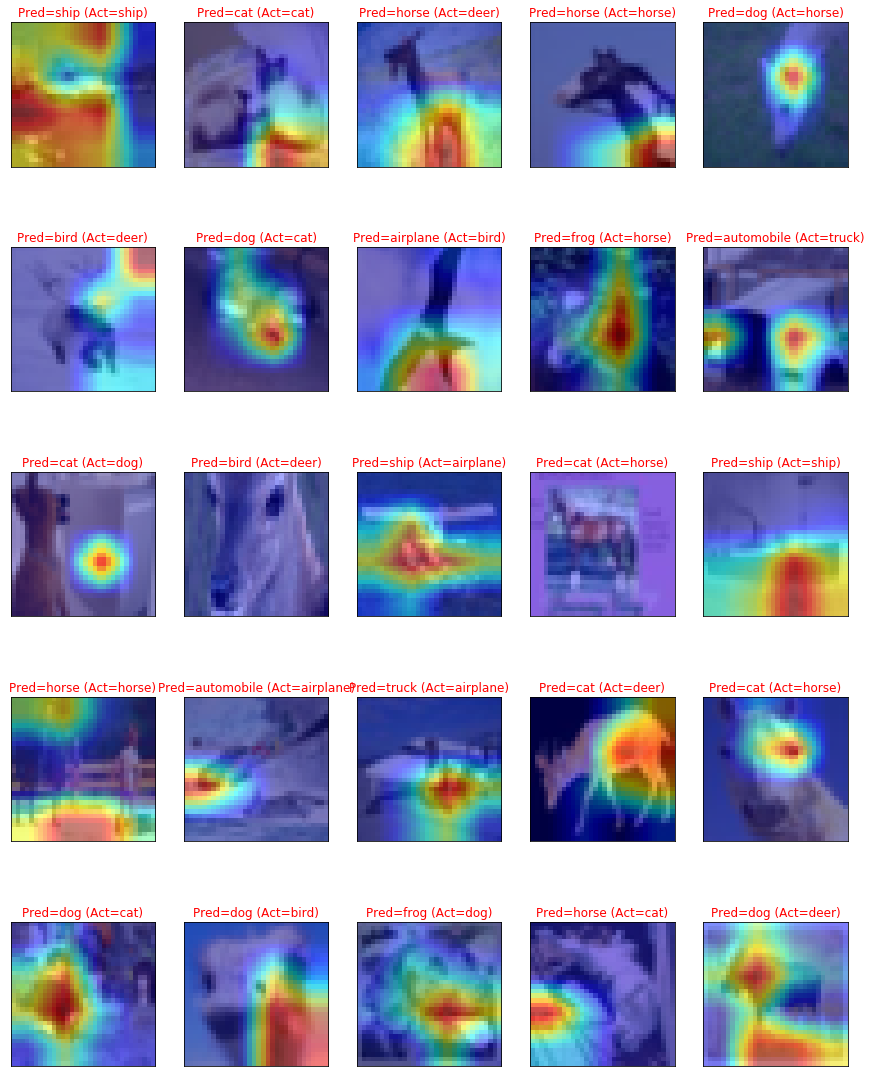

In [20]:
plotdata.PlotData.plotmisclassifiedimages(dataiterator=dataiterator,model=model,classes=classes,
                                          batch_size=batch_size,dogradcam=True,device=device)

In [21]:
utils.Utils.showaccuracyacrossclasses(class_correct=class_correct,class_total=class_total)

Test Accuracy of airplane: 85% (6547/7668)
Test Accuracy of automobile: 92% (7214/7773)
Test Accuracy of  bird: 75% (6060/8005)
Test Accuracy of   cat: 66% (5313/7966)
Test Accuracy of  deer: 81% (6523/8029)
Test Accuracy of   dog: 75% (6028/7971)
Test Accuracy of  frog: 88% (7034/7992)
Test Accuracy of horse: 86% (6829/7897)
Test Accuracy of  ship: 89% (7023/7862)
Test Accuracy of truck: 88% (6924/7837)

Test Accuracy (Overall): 82% (65495/79000)


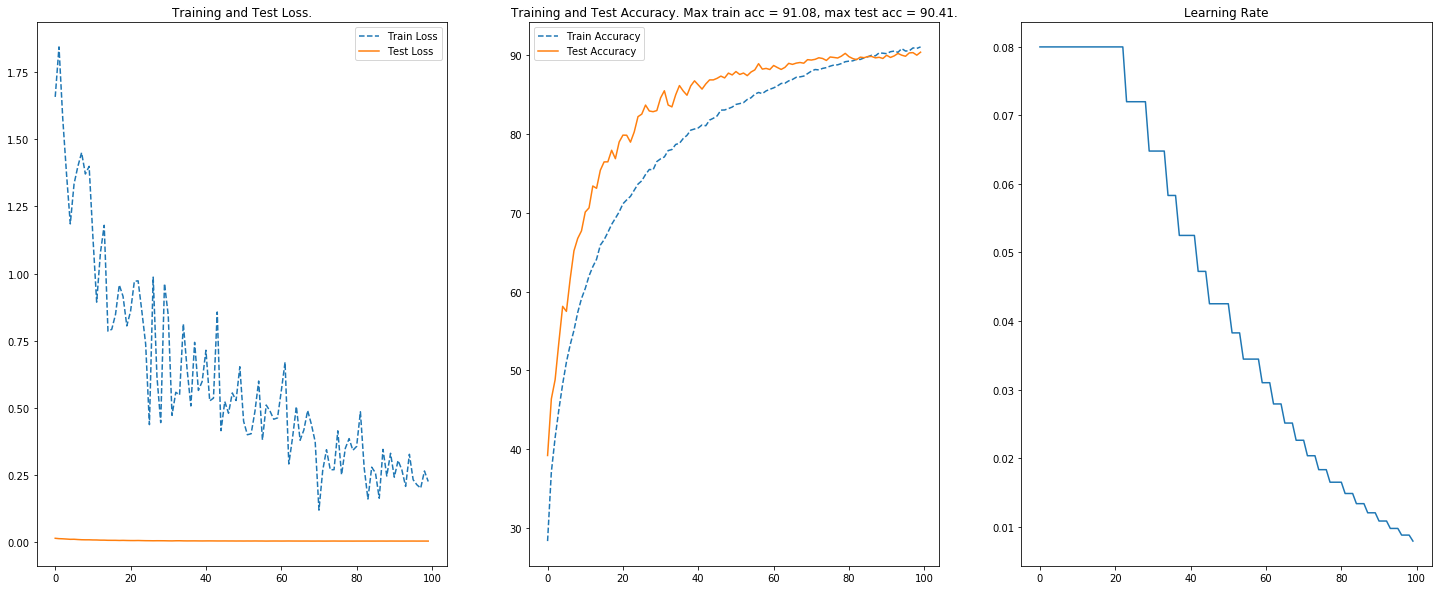

In [22]:
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True,epochs=epoch,doProcessArray=False)

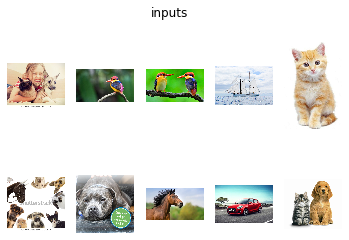

In [26]:
# from src.utils.modelutils import subplot
image_paths = glob.glob('./images/testimages/*.*')
images = list(map(lambda x: Image.open(x), image_paths))
subplot(images, title='inputs', nrows=2, ncols=5)

In [27]:
import torchvision

inputs = [torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])(
    x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

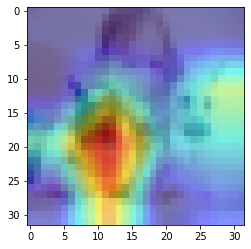

{'prediction': 'dog'}


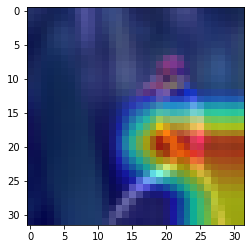

{'prediction': 'bird'}


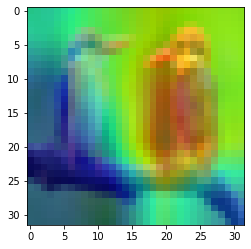

{'prediction': 'frog'}


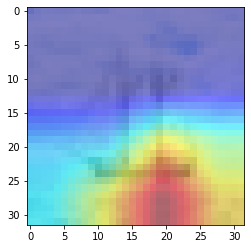

{'prediction': 'ship'}


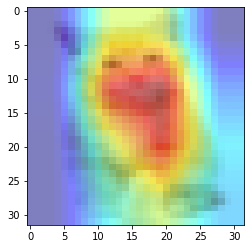

{'prediction': 'cat'}


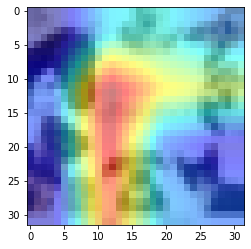

{'prediction': 'dog'}


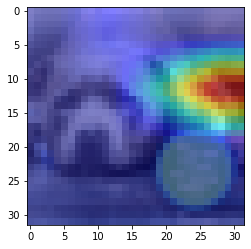

{'prediction': 'cat'}


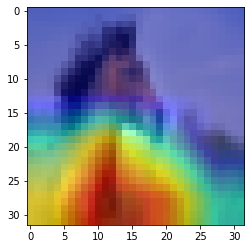

{'prediction': 'horse'}


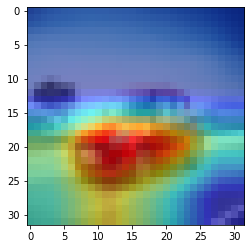

{'prediction': 'automobile'}


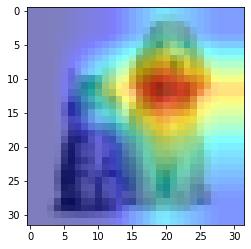

{'prediction': 'dog'}


In [29]:
from src.visualization.gradcam.gradcam import GradCam
from src.visualization.gradcam import gradcamhelper

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

for input in inputs:
    gradcamimg,prediction = gradcamhelper.dogradcam(model=model,image=input,device=device,classes=classes)
#   print(inputs[8])
#   print(gradcamimg)
#   print(inputs[8].shape)
#   print(gradcamimg.shape)
    utils.Utils.imshowt(gradcamimg[0])
    print(prediction)

In [31]:
torch.cuda.empty_cache()

test_dataset = None
train_dataset = None
test_loader = None
train_loader = None

import gc
gc.collect()

13295